<center><font size="10">Mehta Purvil</font></center>
<br><center><font size="6">Github Username: purvilmehta06</font></center>
<br><center><font size="6">USC ID: 6104797766</font></center>

# Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.special import softmax
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")
os.environ['PYTHONWARNINGS'] = 'ignore'

# 1. Supervised, Semi-Supervised, and Unsupervised Learning

## (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [26]:
data_filename = "../data/wdbc.data.csv"
banknote_data_filename = "../data/data_banknote_authentication.txt"
summary = {}

In [3]:
train_data = pd.read_csv(data_filename, header = None)
train_data.replace({'M': 1, 'B': 0}, inplace = True)
train_data.columns = ['id', 'label'] + [f'col{i}' for i in range(1, 31)]
train_data

,id,label,col1,col2,col3,col4,col5,col6,col7,col8,...,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## (b) Monte-Carlo Simulation

In [4]:
def custom_split(train_data, random_state, test_size = 0.2):
    
    np.random.seed(random_state)
    label_0_index, = np.where(train_data['label'] == 0)    
    label_0_test_idx = np.random.choice(label_0_index, round(len(label_0_index) * test_size), replace = False)
    
    label_0_index, = np.where(train_data['label'] == 1)
    label_1_test_idx = np.random.choice(label_0_index, round(len(label_0_index) * test_size), replace = False)
    
    test_idx = np.concatenate([label_0_test_idx, label_1_test_idx])
    train_idx = np.array([i for i in range(train_data.shape[0]) if i not in test_idx])
    
    train_x = train_data.iloc[train_idx, 2:].copy()
    train_y = train_data.iloc[train_idx, 1].copy()
    test_x = train_data.iloc[test_idx, 2:].copy()
    test_y = train_data.iloc[test_idx, 1].copy()
    return train_x, test_x, train_y, test_y

def get_normalized_data(train_x, test_x):    
    return Normalizer().fit_transform(train_x), Normalizer().fit_transform(test_x)

In [5]:
def plot_roc_curve(true_label, prob, title):
    fpr, tpr, thresholds = roc_curve(true_label, prob, pos_label = 1)
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(figsize = (6, 4))
    axes.plot([0, 1], [0, 1], "--")
    axes.plot(fpr, tpr, label = f"ROC Curve Area: {round(roc_auc, 4)}")
    axes.set_title(f"ROC curve for {title}")    
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()
    
def print_results(true_label, pred_label, prob, title):
    calculated_accuracy_score = accuracy_score(true_label, pred_label)
    conf_matrix = confusion_matrix(true_label, pred_label)
    print(f"\nAnalysis Summary for {title}\n")
    print(f'Accuracy Score is: {round(calculated_accuracy_score, 4)}')
    print(f'Confusion Matrix is: \n{conf_matrix}')
    plot_roc_curve(true_label, prob, title) 

def get_stats(model, data_x, data_y):
    probability = model.decision_function(data_x)
    predictions = model.predict(data_x)
    model_results = classification_report(data_y, predictions, output_dict = True)
    fpr, tpr, _ = roc_curve(data_y, probability, pos_label = 1)
    return {
        'local_results': {
            'acc' : model_results['accuracy'],
            'precision' : model_results['weighted avg']['precision'],
            'recall' : model_results['weighted avg']['recall'],
            'f1-score' : model_results['weighted avg']['f1-score'],
            'auc' : round(auc(fpr, tpr), 4)
        },
        'predictions': predictions,
        'probability': probability,
    }

def combine_results(train_df, test_df):
    train_resdf = train_df.apply(lambda x: x.mean(), axis = 0)
    test_resdf = test_df.apply(lambda x: x.mean(), axis = 0)
    data = [train_resdf, test_resdf]
    summary = pd.concat(data, axis = 1).T
    summary.index = ['training', 'test']
    return summary

def monte_carlo_svm(train_data, iterations, model_to_run):
    
    end = 10 if model_to_run == 'semi-supervised-svm' else 20
    kwargs = {
        'param_grid' : {'C' : np.logspace(-2, 7, end)}, 
        'scoring' : 'f1_weighted',
        'n_jobs' : -1
    }
    
    stats = ['acc', 'precision', 'recall', 'f1-score', 'auc']
    train_df = pd.DataFrame(columns = stats)
    test_df = pd.DataFrame(columns = stats)
    print('Iteration\tTrain Accuracy\tTest Accuracy\tBest Params')
    
    for i in range(iterations):
        train_x, test_x, train_y, test_y = custom_split(train_data, i)
        train_x, test_x = get_normalized_data(train_x, test_x)
        train_x, test_x = pd.DataFrame(train_x), pd.DataFrame(test_x)
        
        if (model_to_run == 'supervised-svm'):
            kwargs['cv'] = StratifiedKFold(5, random_state = i, shuffle = True)
            model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
            model.fit(train_x, train_y)
        elif (model_to_run == 'semi-supervised-svm'):
            model = semi_supervised_svm(train_x, train_y, kwargs)
        else:
            model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
            model.fit(train_x, train_y)
            
        train_stats = get_stats(model, train_x, train_y)
        test_stats = get_stats(model, test_x, test_y)
        train_df = train_df.append(train_stats['local_results'], ignore_index = True)
        test_df = test_df.append(test_stats['local_results'], ignore_index = True)
        train_acc, test_acc = train_stats['local_results']['acc'], test_stats['local_results']['acc']
        print(f'{i + 1}\t\t{round(train_acc, 4)}\t\t{round(test_acc, 4)}\t\t{model.best_params_}')
        
    print_results(train_y, train_stats['predictions'], train_stats['probability'], "Training")
    print_results(test_y, test_stats['predictions'], test_stats['probability'], "Testing")
    summary = combine_results(train_df, test_df)
    return summary

### (i) Supervised Learning

In [6]:
train_x, test_x, train_y, test_y = custom_split(train_data, 0)

In [7]:
train_x

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,15.470,23.75,103.40,741.6,0.17910,0.52490,0.5355,0.1741,0.3985,0.12440
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.3784,0.1932,0.3063,0.08368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.2542,0.2929,0.09873
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


In [8]:
test_x

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30
49,13.490,22.30,86.91,561.0,0.08752,0.07698,0.04751,0.033840,0.1809,0.05718,...,15.15,31.82,99.00,698.8,0.1162,0.17110,0.228200,0.128200,0.2871,0.06917
285,12.580,18.40,79.83,489.0,0.08393,0.04216,0.00186,0.002924,0.1697,0.05855,...,13.50,23.08,85.56,564.1,0.1038,0.06624,0.005579,0.008772,0.2505,0.06431
495,14.870,20.21,96.12,680.9,0.09587,0.08345,0.06824,0.049510,0.1487,0.05748,...,16.01,28.48,103.90,783.6,0.1216,0.13880,0.170000,0.101700,0.2369,0.06599
391,8.734,16.84,55.27,234.3,0.10390,0.07428,0.00000,0.000000,0.1985,0.07098,...,10.17,22.80,64.01,317.0,0.1460,0.13100,0.000000,0.000000,0.2445,0.08865
187,11.710,17.19,74.68,420.3,0.09774,0.06141,0.03809,0.032390,0.1516,0.06095,...,13.01,21.39,84.42,521.5,0.1323,0.10400,0.152100,0.109900,0.2572,0.07097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,18.490,17.52,121.30,1068.0,0.10120,0.13170,0.14910,0.091830,0.1832,0.06697,...,22.75,22.88,146.40,1600.0,0.1412,0.30890,0.353300,0.166300,0.2510,0.09445
352,25.730,17.46,174.20,2010.0,0.11490,0.23630,0.33680,0.191300,0.1956,0.06121,...,33.13,23.58,229.30,3234.0,0.1530,0.59370,0.645100,0.275600,0.3690,0.08815
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.149600,0.2395,0.07398,...,26.68,33.48,176.50,2089.0,0.1491,0.75840,0.678000,0.290300,0.4098,0.12840
91,15.370,22.76,100.20,728.2,0.09200,0.10360,0.11220,0.074830,0.1717,0.06097,...,16.43,25.84,107.50,830.9,0.1257,0.19970,0.284600,0.147600,0.2556,0.06828


In [9]:
display(train_y.value_counts())
display(test_y.value_counts())

0    286
1    170
Name: label, dtype: int64

0    71
1    42
Name: label, dtype: int64

Iteration	Train Accuracy	Test Accuracy	Best Params
1		0.9956		0.9646		{'C': 127427.49857031321}
2		0.9759		0.9558		{'C': 1623.776739188721}
3		0.9759		0.9204		{'C': 1623.776739188721}
4		0.989		0.9646		{'C': 14384.498882876629}
5		0.9978		0.9558		{'C': 42813.32398719387}
6		0.9868		0.9469		{'C': 14384.498882876629}
7		0.9781		0.9646		{'C': 14384.498882876629}
8		0.9846		0.9558		{'C': 42813.32398719387}
9		0.9912		0.9735		{'C': 3359818.2862837743}
10		0.9737		1.0		{'C': 4832.930238571752}
11		0.989		0.9381		{'C': 1128837.8916846884}
12		0.9825		0.9912		{'C': 4832.930238571752}
13		0.9803		0.9823		{'C': 4832.930238571752}
14		0.9825		0.9646		{'C': 4832.930238571752}
15		0.9825		0.9558		{'C': 14384.498882876629}
16		0.9912		0.9469		{'C': 14384.498882876629}
17		0.9912		0.9292		{'C': 14384.498882876629}
18		0.9825		0.9823		{'C': 42813.32398719387}
19		0.9737		0.9735		{'C': 14384.498882876629}
20		0.9781		0.9823		{'C': 42813.32398719387}
21		0.9912		0.9646		{'C': 4832.930238571752}
22		0.98

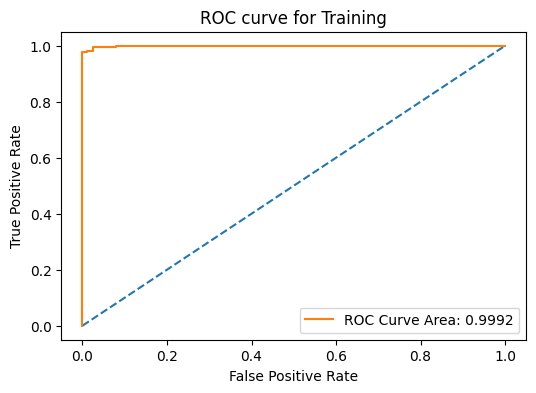


Analysis Summary for Testing

Accuracy Score is: 0.9469
Confusion Matrix is: 
[[69  2]
 [ 4 38]]


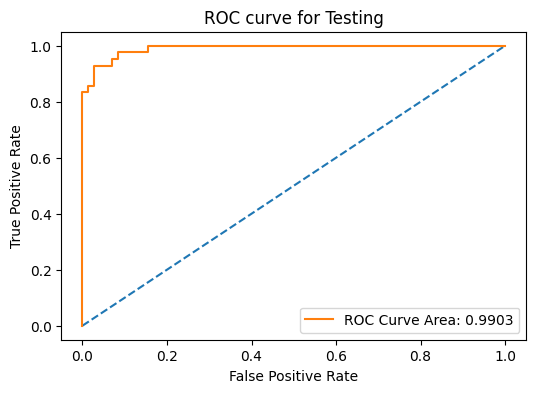

Combining Results.....


,acc,precision,recall,f1-score,auc
training,0.983918,0.983951,0.983918,0.983897,0.998653
test,0.960472,0.960922,0.960472,0.960362,0.988543


In [10]:
summary['supervised-svm'] = monte_carlo_svm(train_data, 30, 'supervised-svm')
df = pd.DataFrame(summary['supervised-svm'])
print("Combining Results.....")
display(df)

### (ii) Semi-Supervised Learning/ Self-training

#### Performing (A) & (B) together

In [11]:
def semi_supervised_svm(train_x, train_y, settings):
    labeled_idx = []
    unlabeled_idx = []
    
    for c in [0, 1]:
        c_label_idx, = np.where(train_y == c)
        labeled_idx.extend(np.random.choice(c_label_idx, round(len(c_label_idx) * 0.5), replace = False))
    
    for i in range(len(train_x)):
        if i not in labeled_idx:
            unlabeled_idx.append(i)

    labeled_x = train_x.iloc[labeled_idx].to_numpy().tolist()
    labeled_y = train_y.iloc[labeled_idx].to_numpy().tolist()
    unlabeled_x = train_x.iloc[unlabeled_idx].to_numpy().tolist()
    unlabeled_y = train_y.iloc[unlabeled_idx].to_numpy().tolist()
    
    model = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **settings)
    model.fit(labeled_x, labeled_y)
    
    while len(unlabeled_x) > 0:
        scores = model.decision_function(unlabeled_x)
        sorted_idx = sorted([i for i in range(len(unlabeled_x))], key = lambda x : abs(scores[x]))
        unlabeled_x = [unlabeled_x[i] for i in sorted_idx]
        unlabeled_y = [unlabeled_y[i] for i in sorted_idx]
        labeled_x.append(unlabeled_x.pop())
        labeled_y.append(unlabeled_y.pop())
        model.best_estimator_.fit(labeled_x, labeled_y) 
    return model

Iteration	Train Accuracy	Test Accuracy	Best Params
1		0.9956		0.9735		{'C': 10000000.0}
2		0.9781		0.9735		{'C': 10000.0}
3		0.989		0.9469		{'C': 10000.0}
4		0.9956		0.9646		{'C': 100000.0}
5		0.989		0.9646		{'C': 10000.0}
6		0.9846		0.9469		{'C': 10000.0}
7		0.9781		0.9646		{'C': 100000.0}
8		0.989		0.9558		{'C': 1000000.0}
9		0.9868		0.9646		{'C': 10000.0}
10		0.9715		1.0		{'C': 10000.0}
11		0.9868		0.9469		{'C': 100000.0}
12		0.989		0.9823		{'C': 100000.0}
13		0.9803		0.9823		{'C': 100000.0}
14		0.989		0.9646		{'C': 10000.0}
15		0.9671		0.9381		{'C': 1000.0}
16		0.9912		0.9381		{'C': 10000.0}
17		0.989		0.9381		{'C': 10000.0}
18		0.9605		0.9735		{'C': 1000.0}
19		0.9825		0.9558		{'C': 100000.0}
20		0.9825		0.9735		{'C': 100000.0}
21		0.9868		0.9646		{'C': 10000.0}
22		0.989		0.9646		{'C': 100000.0}
23		0.9846		0.9558		{'C': 10000000.0}
24		0.9825		0.9381		{'C': 10000.0}
25		0.9715		0.9823		{'C': 10000.0}
26		0.9781		0.9381		{'C': 1000.0}
27		0.9825		0.9558		{'C': 10000.0}
28		0.9715

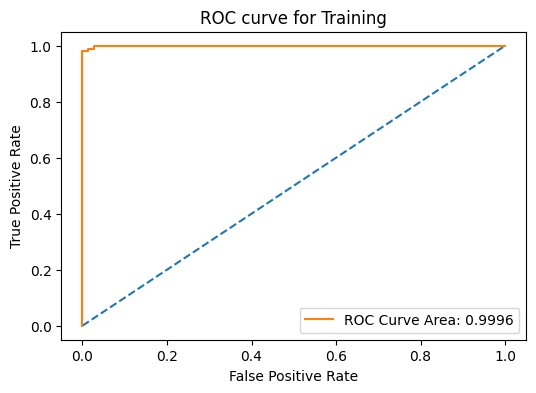


Analysis Summary for Testing

Accuracy Score is: 0.9381
Confusion Matrix is: 
[[69  2]
 [ 5 37]]


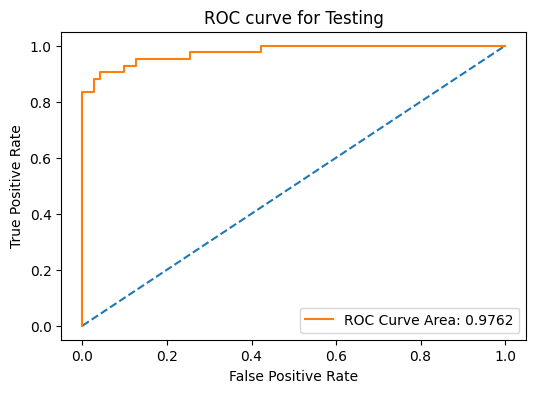

Combining Results.....


,acc,precision,recall,f1-score,auc
training,0.983333,0.983353,0.983333,0.983310,0.998617
test,0.959882,0.960419,0.959882,0.959745,0.988337


In [12]:
summary['semi-supervised-svm'] = monte_carlo_svm(train_data, 30, 'semi-supervised-svm')
df = pd.DataFrame(summary['semi-supervised-svm'])
print("Combining Results.....")
display(df)

### (iii) Unsupervised Learning

#### (A) How do you make sure that the algorithm was not trapped in a local minimum?
**Ans : We should set the number of iterations to avoid being trapped in a local minimum.**

#### Performing (A), (B) and (C) together

In [13]:
def get_local_results(true_labels, probability, report):
    fpr, tpr, _ = roc_curve(true_labels, probability, pos_label = 1)
    roc_auc = round(auc(fpr, tpr), 4)
    return {
        'acc' : report['accuracy'],
        'precision' : report['weighted avg']['precision'],
        'recall' : report['weighted avg']['recall'],
        'f1-score' : report['weighted avg']['f1-score'],
        'auc' : roc_auc
    }

def get_distance(centers, X, cluster_label):
    dist = np.ndarray((X.shape[0],))
    proba = np.ndarray((X.shape[0], 2))
    for i, x in enumerate(X):
        center = centers[cluster_label[i]]
        dist[i] = np.linalg.norm(x - center)
        proba[i, 0] = np.linalg.norm(x - centers[0])
        proba[i, 1] = np.linalg.norm(x - centers[1])
    
    proba = softmax(proba, axis=1).astype(np.float64)
    return dist, proba

def get_majority(cluster_label, dist, Y):
    label2cluster = np.ndarray((2,), dtype='int')
    major_label = cluster_label.copy()
    for cluster in [0, 1]:
        sample_idx, = np.where(cluster_label == cluster)
        top30 = sorted(sample_idx.tolist(), key=lambda i : dist[i])[:30]
        majority = Y.iloc[top30].value_counts().index[0]
        major_label[sample_idx] = majority
        label2cluster[majority] = cluster
    return label2cluster, major_label

def monte_carlo_unsupervised(data, n, model_to_run):
    
    stats = ['acc', 'precision', 'recall', 'f1-score', 'auc']
    train_df = pd.DataFrame(columns = stats)
    test_df = pd.DataFrame(columns = stats)
    print('Iteration\tTrain Accuracy\tTest Accuracy')
    
    for i in range(n):
        train_x, test_x, train_y, test_y = custom_split(data, i)
        train_x, test_x = get_normalized_data(train_x, test_x)
        
        if model_to_run == 'unsupervised-kmeans':
            model = KMeans(n_clusters = 2, n_init = 15, random_state = i).fit(train_x)
            predicted_label = model.predict(train_x)
            cluster_centroid = model.cluster_centers_
        else:  
            cluster_label = SpectralClustering(n_clusters = 2, assign_labels = 'kmeans', affinity = 'rbf', 
                                               eigen_tol = 1e-2, eigen_solver = 'arpack', random_state = 0
                                              ).fit_predict(train_x)
            cluster_centroid = []
            cluster_centroid.append(np.mean(train_x[cluster_label == 0], axis = 0).tolist())
            cluster_centroid.append(np.mean(train_x[cluster_label == 1], axis = 0).tolist())
            model = KNeighborsClassifier(n_neighbors = 1).fit(train_x, cluster_label)
            predicted_label = model.predict(train_x)
        
        distance, probability = get_distance(cluster_centroid, train_x, predicted_label)
        label2cluster, predictions = get_majority(predicted_label, distance, train_y)
        probability = probability[:, label2cluster[0]]
        model_results = classification_report(train_y, predictions, output_dict = True)
        local_result = get_local_results(train_y, probability, model_results)
        train_df = train_df.append(local_result, ignore_index = True)
        
        # testing
        predicted_label_test = model.predict(test_x)
        distance_test, probability_test = get_distance(cluster_centroid, test_x, predicted_label_test)
        label2cluster, predictions_test = get_majority(predicted_label_test, distance_test, test_y)
        probability_test = probability_test[:, label2cluster[0]]
        model_results_test = classification_report(test_y, predictions_test, output_dict = True)
        local_result_test = get_local_results(test_y, probability_test, model_results_test)
        test_df = test_df.append(local_result_test, ignore_index = True)
        
        train_acc = model_results['accuracy']
        test_acc = model_results_test['accuracy']
        print(f'{i + 1}\t\t{round(train_acc, 4)}\t\t{round(test_acc, 4)}')
    
    
    print_results(train_y, predictions, probability, 'Training')
    print_results(test_y, predictions_test, probability_test, 'Test')
    summary = combine_results(train_df, test_df)
    return summary

Iteration	Train Accuracy	Test Accuracy
1		0.8882		0.8761
2		0.8706		0.9558
3		0.8969		0.8496
4		0.886		0.9115
5		0.8991		0.8761
6		0.886		0.8673
7		0.8794		0.8938
8		0.886		0.8673
9		0.8882		0.8584
10		0.8794		0.8938
11		0.8925		0.8761
12		0.8794		0.9115
13		0.8816		0.9027
14		0.8882		0.8938
15		0.8969		0.8496
16		0.8772		0.9027
17		0.9013		0.8319
18		0.8838		0.9115
19		0.886		0.885
20		0.8991		0.8584
21		0.8838		0.9115
22		0.8794		0.8938
23		0.8882		0.885
24		0.8904		0.8496
25		0.8947		0.8761
26		0.8991		0.8407
27		0.8838		0.9027
28		0.886		0.8938
29		0.8904		0.9027
30		0.8925		0.8407

Analysis Summary for Training

Accuracy Score is: 0.8925
Confusion Matrix is: 
[[282   4]
 [ 45 125]]


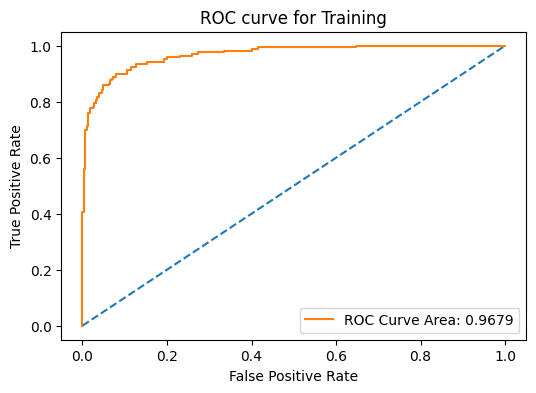


Analysis Summary for Test

Accuracy Score is: 0.8407
Confusion Matrix is: 
[[70  1]
 [17 25]]


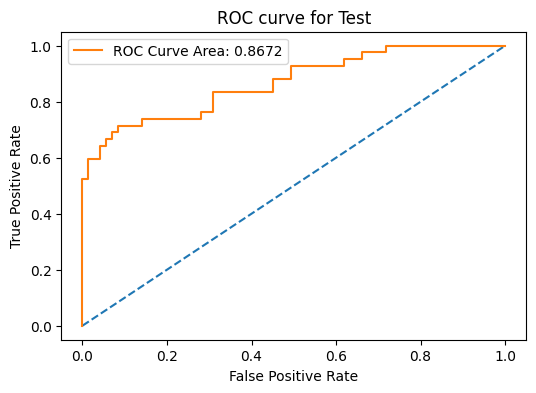

Combining Results.....


,acc,precision,recall,f1-score,auc
training,0.887792,0.896542,0.887792,0.883912,0.950717
test,0.882301,0.894138,0.882301,0.877143,0.945860


In [14]:
summary['unsupervised-kmeans'] = monte_carlo_unsupervised(train_data, 30, 'unsupervised-kmeans')
df = pd.DataFrame(summary['unsupervised-kmeans'])
print("Combining Results.....")
display(df)

### (iv) Spectral Clustering

Iteration	Train Accuracy	Test Accuracy
1		0.886		0.885
2		0.8684		0.9204
3		0.8925		0.8407
4		0.8794		0.8761
5		0.8838		0.8761
6		0.8838		0.8761
7		0.8728		0.8938
8		0.8838		0.8496
9		0.886		0.8496
10		0.8772		0.8761
11		0.8904		0.8496
12		0.8794		0.8938
13		0.8794		0.8938
14		0.8794		0.885
15		0.8925		0.8053
16		0.8728		0.885
17		0.8947		0.823
18		0.8816		0.9292
19		0.8838		0.8761
20		0.8925		0.8584
21		0.875		0.9115
22		0.8794		0.885
23		0.8838		0.8761
24		0.8838		0.8496
25		0.8882		0.8496
26		0.8925		0.8407
27		0.8772		0.8938
28		0.8772		0.885
29		0.8772		0.8938
30		0.8925		0.823

Analysis Summary for Training

Accuracy Score is: 0.8925
Confusion Matrix is: 
[[282   4]
 [ 45 125]]


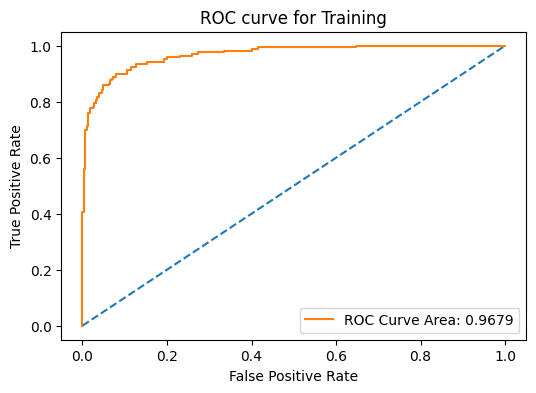


Analysis Summary for Test

Accuracy Score is: 0.823
Confusion Matrix is: 
[[69  2]
 [18 24]]


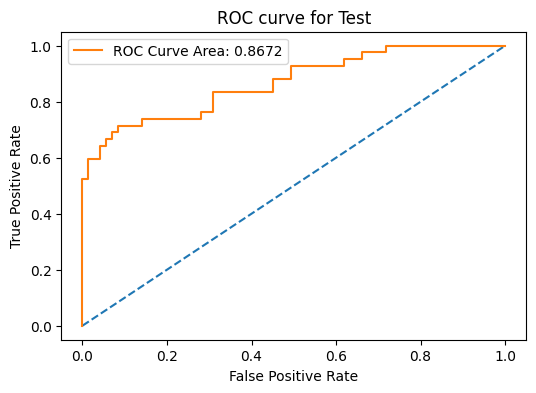

Combining Results.....


,acc,precision,recall,f1-score,auc
training,0.882895,0.893003,0.882895,0.878464,0.950147
test,0.871681,0.885106,0.871681,0.865377,0.945257


In [15]:
summary['unsupervised-spectral'] = monte_carlo_unsupervised(train_data, 30, 'unsupervised-spectral')
df = pd.DataFrame(summary['unsupervised-spectral'])
print("Combining Results.....")
display(df)

### (iv) Compare

In [25]:
for key in summary.keys():
    print('-'*60 + '\n' + key + '\n' + '-'*60 + '\n', summary[key])

------------------------------------------------------------
supervised-svm
------------------------------------------------------------
                acc  precision    recall  f1-score       auc
training  0.983918   0.983951  0.983918  0.983897  0.998653
test      0.960472   0.960922  0.960472  0.960362  0.988543
------------------------------------------------------------
semi-supervised-svm
------------------------------------------------------------
                acc  precision    recall  f1-score       auc
training  0.983333   0.983353  0.983333  0.983310  0.998617
test      0.959882   0.960419  0.959882  0.959745  0.988337
------------------------------------------------------------
KMeans
------------------------------------------------------------
                acc  precision    recall  f1-score       auc
training  0.887792   0.896542  0.887792  0.883912  0.950717
test      0.882301   0.894138  0.882301  0.877143  0.945860
-------------------------------------------------

### Findings

After reviewing the summarization outcomes, it can be concluded that the performance of the supervised method is superior to the semi-supervised method, which, in turn, outperforms the unsupervised method. However, the difference in performance between the semi-supervised and unsupervised methods is more distinct and significant than the difference between the supervised and semi-supervised methods. This trend is not surprising, as the supervised approach has more label information to guide its predictions, while the semi-supervised approach has less. On the other hand, the unsupervised method relies on the similarity of features to make predictions, and therefore it does not perform as well as the supervised or semi-supervised methods.

# 2. Active Learning Using Support Vector Machines

## (a) Download the banknote authentication Data Set

In [27]:
train_data = pd.read_csv(banknote_data_filename, header = None)
train_data.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
train_data

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [45]:
def random_split(train_data):    

    test_idx = np.random.choice(train_data.shape[0], 472, replace = False)
    temp_list = []
    for i in range(train_data.shape[0]):
        if i not in test_idx:
            temp_list.append(i); 
    train_idx = np.array(temp_list)
    train_x = train_data.iloc[train_idx]
    test_x = train_data.iloc[test_idx]
    return train_x, test_x

train_x, test_x = random_split(train_data)

0    513
1    387
Name: class, dtype: int64

In [34]:
train_x

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.80730,-0.44699,0
3,3.45660,9.52280,-4.01120,-3.59440,0
4,0.32924,-4.45520,4.57180,-0.98880,0
5,4.36840,9.67180,-3.96060,-3.16250,0
6,3.59120,3.01290,0.72888,0.56421,0
...,...,...,...,...,...
1366,-2.41000,3.74330,-0.40215,-1.29530,1
1367,0.40614,1.34920,-1.45010,-0.55949,1
1369,-3.75030,-13.45860,17.59320,-2.77710,1
1370,-3.56370,-8.38270,12.39300,-1.28230,1


In [35]:
test_x

,variance,skewness,curtosis,entropy,class
1030,-1.8439,-8.6475,7.67960,-0.66682,1
236,-1.3274,9.4980,2.44080,-5.26890,0
190,0.9297,-3.7971,4.64290,-0.29570,0
105,3.5438,1.2395,1.99700,2.15470,0
1247,-4.4775,-13.0303,17.08340,-3.03450,1
...,...,...,...,...,...
10,1.2247,8.7779,-2.21350,-0.80647,0
544,4.2458,1.1981,0.66633,0.94696,0
1256,-2.1652,3.0211,-2.41320,-2.42410,1
840,-2.2580,-9.3263,9.37270,-0.85949,1


## (b) Repeat each of the following two procedures 50 times

In [48]:
def passive_learning(train_x, train_y, test_x, test_y, kwargs):
    all_idx = np.arange(train_x.shape[0])
    new_idx, accuracy = [], []
    while len(all_idx) > 0:
        np.random.shuffle(all_idx)
        pool, all_idx = all_idx[:10], all_idx[10:]
        new_idx.extend(pool)
        
        new_train_x, new_train_y = train_x.iloc[new_idx], train_y.iloc[new_idx]
        model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
        model.fit(new_train_x, new_train_y)
        predictions = model.predict(test_x)
        result = classification_report(test_y, predictions, output_dict = True)
        accuracy.append(result['accuracy'])
    return accuracy

def active_learning(train_x, train_y, test_x, test_y, kwargs):
    all_idx = np.arange(train_x.shape[0])
    new_idx, accuracy = [], []
    np.random.shuffle(all_idx)
    pool, all_idx = all_idx[:10], all_idx[10:]
    new_idx.extend(pool)
    
    while len(new_idx) <= 900:
        new_train_x, new_train_y = train_x.iloc[new_idx], train_y.iloc[new_idx]
        model = GridSearchCV(estimator = LinearSVC(penalty = 'l1', dual = False), **kwargs)
        model.fit(new_train_x, new_train_y)
        predictions = model.predict(test_x)
        result = classification_report(test_y, predictions, output_dict = True)
        accuracy.append(result['accuracy'])
        
        if len(all_idx) == 0:
            break
        
        dist = model.decision_function(train_x.iloc[all_idx])
        sortedarg = np.arange(len(all_idx))
        sorted(sortedarg, key=lambda i : abs(dist[i]))
        all_idx = all_idx[sortedarg]
        pool, all_idx = all_idx[:10], all_idx[10:]
        new_idx.extend(pool)
        
    return accuracy

def monte_carlo_active_passive(train_data, iterations, _type):

    kwargs = {
        'param_grid' : {'C' : np.logspace(-2, 7, 20)}, 
        'scoring' : 'f1_weighted',
        'n_jobs' : -1
    }
    
    learning_curve = []   
    print('Iteration\tTrain Accuracy\tTest Accuracy')
    for i in range(iterations):
        train_df, test_df = random_split(train_data)
        train_x, train_y = train_df.iloc[:, :-1], train_df.iloc[:, -1]
        test_x, test_y = test_df.iloc[:, :-1], test_df.iloc[:, -1]
        train_x, test_x = get_normalized_data(train_x, test_x)
        train_x, test_x = pd.DataFrame(train_x), pd.DataFrame(test_x)
        kwargs['cv'] = StratifiedKFold(5, random_state = i, shuffle = True)
         
        if _type == 'passive':  
            accuracy = passive_learning(train_x, train_y, test_x, test_y, kwargs)
        else:
            accuracy = active_learning(train_x, train_y, test_x, test_y, kwargs)
        learning_curve.append(accuracy)
        print(f'{i + 1}\t\t{round(accuracy[0], 4)}\t\t{round(accuracy[-1], 4)}')

    learning_curve = np.mean(np.array(learning_curve), axis = 0)
    return learning_curve

def plot_learning_curve(active, passive):
    
    fig, axes = plt.subplots(figsize=(6, 4))
    x = 10 * np.arange(1, 91)
    axes.plot(x, 1 - passive, label = 'Passive')
    axes.plot(x, 1 - active, label = 'Active')
    axes.set_title("Learning Curve")
    axes.set_xlabel("Training Size")
    axes.set_ylabel("Test Error")
    axes.legend()
    plt.show()

### (i) Passive

In [49]:
passive_learning_curve = monte_carlo_active_passive(train_data, 50, 'passive')

Iteration	Train Accuracy	Test Accuracy
1		0.8581		0.9936
2		0.8178		0.9894
3		0.7987		0.9915
4		0.8347		0.9873
5		0.8644		0.9915
6		0.964		0.9894
7		0.8411		0.9873
8		0.7669		0.9894
9		0.9407		0.9936
10		0.9068		0.9915
11		0.8665		0.9958
12		0.7669		0.9894
13		0.8284		0.9894
14		0.7669		0.9936
15		0.8411		0.9958
16		0.8517		0.9979
17		0.8559		0.9979
18		0.8369		0.9979
19		0.7733		0.9958
20		0.7373		0.9958
21		0.8898		0.9915
22		0.697		0.9958
23		0.8157		0.9979
24		0.8644		0.9873
25		0.9153		0.9958
26		0.6441		0.9936
27		0.9428		0.9873
28		0.9237		0.9852
29		0.5403		0.9979
30		0.5466		0.9915
31		0.9915		0.9979
32		0.911		1.0
33		0.964		0.9936
34		0.8326		0.9831
35		0.5318		1.0
36		0.8517		0.9958
37		0.6462		0.9915
38		0.7712		0.9936
39		0.8559		0.9873
40		0.8517		0.9873
41		0.9131		0.9873
42		0.8941		0.9958
43		0.7436		0.9915
44		0.9873		0.9958
45		0.7669		0.9958
46		0.9534		1.0
47		0.8623		0.9979
48		0.7797		0.9915
49		0.8962		0.9958
50		0.8771		0.9894


### (ii) Active

In [50]:
active_learning_curve = monte_carlo_active_passive(train_data, 50, 'active')

Iteration	Train Accuracy	Test Accuracy
1		0.8347		0.9958
2		0.9068		0.9915
3		0.8856		0.9958
4		0.8284		0.9979
5		0.8538		0.9915
6		0.8305		0.9936
7		0.9492		0.9915
8		0.8919		0.9894
9		0.8157		0.9936
10		0.7818		0.9915
11		0.803		0.9958
12		0.9089		0.9915
13		0.8369		0.9936
14		0.9153		0.9894
15		0.8771		0.9936
16		0.8559		0.9894
17		0.8517		0.9958
18		0.9534		0.9894
19		0.9555		0.9936
20		0.9555		0.9894
21		0.6208		0.9873
22		0.9449		0.9915
23		0.8496		0.9873
24		0.7712		0.9936
25		0.8411		0.9852
26		0.9746		0.9915
27		0.8538		0.9936
28		0.9068		0.9979
29		0.8729		0.9915
30		0.9089		0.9958
31		0.8284		0.9936
32		0.8284		0.9936
33		0.7691		0.9958
34		0.8305		0.9936
35		0.9343		0.9894
36		0.8962		0.9915
37		0.839		0.9915
38		0.8814		0.9979
39		0.7394		0.9958
40		0.8538		0.9936
41		0.9576		1.0
42		0.9343		0.9894
43		0.9873		0.9894
44		0.7691		0.9936
45		0.8559		0.9936
46		0.8962		0.9936
47		0.822		0.9873
48		0.9788		0.9915
49		0.7648		0.9936
50		0.9428		0.9936


## (c) Average the 50 test errors

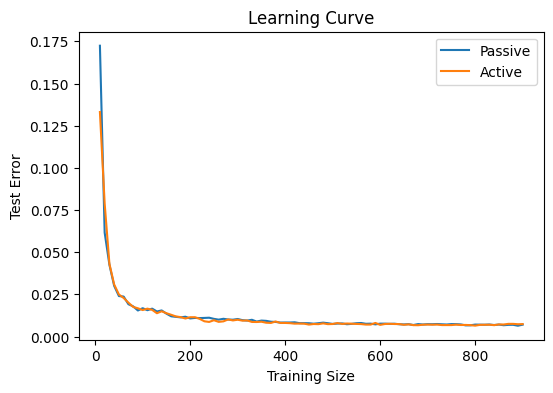

In [51]:
plot_learning_curve(active_learning_curve, passive_learning_curve)

### Findings:

In active learning, the model selects the most informative data points to query for labels, which helps to improve the accuracy of the model with fewer labeled examples. On the other hand, in passive learning, the model uses all available labeled data without any selection strategy.

Therefore, active learning can help to improve model performance by selecting the most informative examples for labeling, leading to a more diverse and representative set of labeled data, reducing the chances of overfitting, and reducing the impact of noisy labels.